In [1]:
from pathlib import Path
import json
import re
from tqdm import tqdm
import sys
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")
WORK_DIR = Path().absolute()
sys.path.append(str(WORK_DIR.parent))

In [2]:
from energyvslatconst import energyvslatconst

In [3]:
# Read settings
ROOT_DIR = WORK_DIR.parent
SETTINGS_DIR = ROOT_DIR / "settings"

settings_path = SETTINGS_DIR / "settings0.json"
with open(settings_path, "r") as f:
    settings = json.load(f)

RES_DIR = WORK_DIR / "results" / re.match(r"^[^_\.]+", settings_path.name).group()
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)
PLOT_DIR = RES_DIR / "plots"
if not PLOT_DIR.exists():
    PLOT_DIR.mkdir(parents=True)

In [4]:
# DFT data
dft_data = np.loadtxt("../energyvslatconst/dft_data.txt", delimiter=",")

In [5]:
##########################################################################################
# Loss trajectory
# ---------------
# Compute the energy ensembles
ainit = 2.466
alist = np.linspace(0.93, 1.09, 21) * ainit
preds_samples_file = RES_DIR / "uncertainty_energy_vs_latconst_graphene.npz"
if preds_samples_file.exists():
    preds_data = np.load(preds_samples_file)
    energy_ensembles = preds_data["energy_ensembles"]
else:
    energy_ensembles = np.empty((0, len(alist)))
    for set_idx in tqdm(range(100)):
        # Predictions
        modelname = f"DUNN_C_losstraj_{set_idx:03d}"
        _, elist = energyvslatconst(modelname, alist, "graphene", 0)
        energy_ensembles = np.row_stack((energy_ensembles, elist))
    energy_ensembles = energy_ensembles.astype(float)
    np.savez(preds_samples_file, alist=alist, energy_ensembles=energy_ensembles)

In [6]:
energy_mean = np.mean(energy_ensembles, axis=0)
energy_error = np.std(energy_ensembles, axis=0)

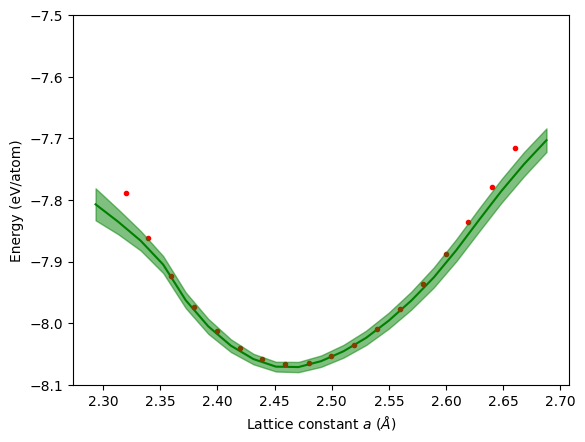

In [7]:
# Plot the result curves
# Energy vs lattice constant
plt.figure()
plt.plot(*(dft_data.T), "r.", zorder=10, label="DFT")

# Random init
plt.fill_between(
    alist,
    energy_mean - energy_error,
    energy_mean + energy_error,
    alpha=0.5,
    color="g",
    zorder=10,
)
plt.plot(alist, energy_mean, "-", color="g", label="DUNN random init")
plt.ylim(-8.1, -7.5)
plt.xlabel(r"Lattice constant $a$ $(\AA)$")
plt.ylabel("Energy (eV/atom)")

plt.show()